## 1. Importing the Data
<p><img src="https://assets.datacamp.com/production/project_1230/img/nyc.jpg" alt="New York City skyline" width="600px">
<br>
Welcome to New York City (NYC), one of the most-visited cities in the world. 
As a result, there are many <a href="https://www.airbnb.com/"><em>Airbnb</em></a> listings to meet the high demand for temporary lodging for anywhere between a few nights to many months. 
In this notebook, we will take a look at the NYC Airbnb market by combining data from multiple file types like <code>.csv</code>, <code>.tsv</code>, and <code>.xlsx</code>.</p>
<p><br><br>
We will be working with three datasets:</p>
<ol>
<li><p><code>"datasets/airbnb_price.csv"</code></p></li>
<li><p><code>"datasets/airbnb_room_type.xlsx"</code></p></li>
<li><p><code>"datasets/airbnb_last_review.tsv"</code></p></li>
</ol>
<p><br><br>
Our goals are to convert untidy data into appropriate formats to analyze, and answer key questions including:</p>
<ul>
<li>What is the average price, per night, of an Airbnb listing in NYC? </li>
<li>How does the average price of an Airbnb listing, per month, compare to the private rental market? </li>
<li>How many adverts are for private rooms? </li>
<li>How do Airbnb listing prices compare across the five NYC boroughs?</li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
# Load airbnb_price.csv, prices
prices = pd.read_csv("datasets/airbnb_price.csv")

# Load airbnb_room_type.xlsx, xls
xls = pd.ExcelFile("datasets/airbnb_room_type.xlsx")

# Parse the first sheet from xls, room_types
room_types = xls.parse(0)

# Load airbnb_last_review.tsv, reviews
reviews = pd.read_csv("datasets/airbnb_last_review.tsv", sep="\t")

# Print the first five rows of each DataFrame
print(prices.head(), "\n", room_types.head(), "\n", reviews.head())

C:\Users\USER\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


   listing_id        price                nbhood_full
0        2595  225 dollars         Manhattan, Midtown
1        3831   89 dollars     Brooklyn, Clinton Hill
2        5099  200 dollars     Manhattan, Murray Hill
3        5178   79 dollars  Manhattan, Hell's Kitchen
4        5238  150 dollars       Manhattan, Chinatown 
    listing_id                                description        room_type
0        2595                      Skylit Midtown Castle  Entire home/apt
1        3831            Cozy Entire Floor of Brownstone  Entire home/apt
2        5099  Large Cozy 1 BR Apartment In Midtown East  Entire home/apt
3        5178            Large Furnished Room Near B'way     private room
4        5238         Cute & Cozy Lower East Side 1 bdrm  Entire home/apt 
    listing_id    host_name   last_review
0        2595     Jennifer   May 21 2019
1        3831  LisaRoxanne  July 05 2019
2        5099        Chris  June 22 2019
3        5178     Shunichi  June 24 2019
4        5238          

## 2. Cleaning the price column
<p>Now the <code>DataFrames</code> have been loaded, the first step is to calculate the average price per listing by <code>room_type</code>. </p>
<p>You may have noticed that the <code>price</code> column in the <code>prices</code> DataFrame currently states each value as a string with the currency (dollars) following, i.e.,</p>
<pre><code>price
225 dollars
89 dollars
200 dollars</code></pre>
<p></p>
<p>We will need to clean the column in order to calculate the average price.</p>

In [2]:
# Remove whitespace and string characters from prices column
prices["price"] = prices["price"] .str.replace(" dollars", "")

# Convert prices column to numeric datatype
prices["price"] =pd.to_numeric(prices["price"])
# Print descriptive statistics for the price column
print(prices["price"].describe())

count    25209.000000
mean       141.777936
std        147.349137
min          0.000000
25%         69.000000
50%        105.000000
75%        175.000000
max       7500.000000
Name: price, dtype: float64


## 3. Calculating average price
<p>We can see three quarters of listings cost \$175 per night or less. </p>
<p>However, there are some outliers including a maximum price of \$7,500 per night! </p>
<p>Some of listings are actually showing as free. Let's remove these from the <code>DataFrame</code>, and calculate the average price.</p>

In [3]:
# Subset prices for listings costing $0, free_listings
free_listings = prices["price"] == 0

# Update prices by removing all free listings from prices
prices = prices.loc[~free_listings]

# Calculate the average price, avg_price
avg_price = round(prices["price"].mean(), 2)

# Print the average price
print("The average price per night for an Airbnb listing in NYC is ${}.".format(avg_price))

The average price per night for an Airbnb listing in NYC is $141.82.


## 4. Comparing costs to the private rental market
<p>Now we know how much a listing costs, on average, per night, but it would be useful to have a benchmark for comparison. 
According to <a href="https://www.zumper.com/rent-research">Zumper</a>, a 1 bedroom apartment in New York City costs, on average, $3,100 per month. Let's convert the per night prices of our listings into monthly costs, so we can compare to the private market. </p>

In [4]:
# Add a new column to the prices DataFrame, price_per_month
prices["price_per_month"] = prices["price"] * 365 / 12

# Calculate average_price_per_month
average_price_per_month = round(prices["price_per_month"].mean(), 2)

# Compare Airbnb and rental market
print("Airbnb monthly costs are ${}, while in the private market you would pay {}.".format(average_price_per_month, "$3,100.00"))

Airbnb monthly costs are $4313.61, while in the private market you would pay $3,100.00.


## 5. Cleaning the room type column
<p>Unsurprisingly, using Airbnb appears to be substantially more expensive than the private rental market. We should, however, consider that these Airbnb listings include single private rooms or even rooms to share, as well as entire homes/apartments. 
<br><br>
Let's dive deeper into the <code>room_type</code> column to find out the breakdown of listings by type of room. The <code>room_type</code> column has several variations for <code>private room</code> listings, specifically: </p>
<ul>
<li>"Private room"</li>
<li>"private room"</li>
<li>"PRIVATE ROOM"</li>
</ul>
<p>We can solve this by converting all string characters to lower case (upper case would also work just fine). </p>

In [5]:
# Convert the room_type column to lowercase
room_types["room_type"] = room_types["room_type"].str.lower()

# Update the room_type column to category data type
room_types["room_type"] = room_types["room_type"].astype("category")

# Create the variable room_frequencies
room_frequencies = room_types["room_type"].value_counts()

# Print room_frequencies
print(room_frequencies)

entire home/apt    13266
private room       11356
shared room          587
Name: room_type, dtype: int64


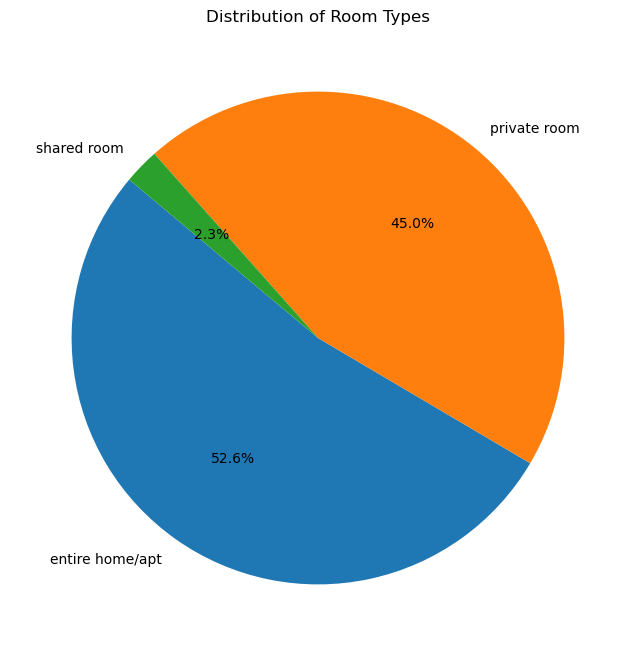

In [6]:
#Distribution of Room Types
plt.figure(figsize=(8, 8))
room_type_counts = room_types["room_type"].value_counts()
plt.pie(room_type_counts, labels=room_type_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Room Types")
plt.show()


## 6. What timeframe are we working with?
<p>It seems there is a fairly similar sized market opportunity for both private rooms (45% of listings) and entire homes/apartments (52%) on the Airbnb platform in NYC.
<br><br></p>
<p>Now let's turn our attention to the <code>reviews</code> DataFrame. The <code>last_review</code> column contains the date of the last review in the format of "Month Day Year" e.g., May 21 2019. We've been asked to find out the earliest and latest review dates in the DataFrame, and ensure the format allows this analysis to be easily conducted going forwards. </p>

In [7]:
# Change the data type of the last_review column to datetime
reviews["last_review"] = pd.to_datetime(reviews["last_review"])

# Create first_reviewed, the earliest review date
first_reviewed = reviews["last_review"].dt.date.min()

# Create last_reviewed, the most recent review date
last_reviewed = reviews["last_review"].dt.date.max()

# Print the oldest and newest reviews from the DataFrame
print("The earliest Airbnb review is {}, the latest review is {}".format(first_reviewed, last_reviewed))

The earliest Airbnb review is 2019-01-01, the latest review is 2019-07-09


## 7. Joining the DataFrames.
<p>Now we've extracted the information needed, we will merge the three DataFrames to make any future analysis easier to conduct. Once we have joined the data, we will remove any observations with missing values and check for duplicates.</p>

In [8]:
# Merge prices and room_types to create rooms_and_prices
rooms_and_prices = prices.merge(room_types, how="outer", on="listing_id")

# Merge rooms_and_prices with the reviews DataFrame to create airbnb_merged
airbnb_merged = rooms_and_prices.merge(reviews, how="outer", on="listing_id")

# Drop missing values from airbnb_merged
airbnb_merged.dropna(inplace=True)

# Check if there are any duplicate values
print("There are {} duplicates in the DataFrame.".format(airbnb_merged.duplicated().sum()))

There are 0 duplicates in the DataFrame.


## 8. Analyzing listing prices by NYC borough
<p>Now we have combined all data into a single DataFrame, we will turn our attention to understanding the difference in listing prices between <a href="https://en.wikipedia.org/wiki/Boroughs_of_New_York_City">New York City boroughs</a>. 
We can currently see boroughs listed as the first part of a string within the <code>nbhood_full</code> column, e.g., </p>
<pre><code>Manhattan, Midtown
Brooklyn, Clinton Hill
Manhattan, Murray Hill
Manhattan, Hell's Kitchen
Manhattan, Chinatown</code></pre>
<p></p>
<p>We will therefore need to extract this information from the string and store in a new column, <code>borough</code>, for analysis.</p>

In [9]:
# Extract information from the nbhood_full column and store as a new column, borough
airbnb_merged["borough"] = airbnb_merged["nbhood_full"].str.partition(",")[0]

# Group by borough and calculate summary statistics
boroughs = airbnb_merged.groupby("borough")["price"].agg(["sum", "mean", "median", "count"])

# Round boroughs to 2 decimal places, and sort by mean in descending order
boroughs = boroughs.round(2).sort_values("mean", ascending=False)

# Print boroughs
print(boroughs)

                     sum    mean  median  count
borough                                        
Manhattan      1898417.0  184.04   149.0  10315
Brooklyn       1275250.0  122.02    95.0  10451
Queens          320715.0   92.83    70.0   3455
Staten Island    22974.0   86.04    71.0    267
Bronx            55156.0   79.25    65.0    696


## 9. Price range by borough
<p>The above output gives us a summary of prices for listings across the 5 boroughs. In this final task we would like to categorize listings based on whether they fall into specific price ranges, and view this by borough. 
<br><br>
We can do this using percentiles and labels to create a new column, <code>price_range</code>, in the DataFrame.
Once we have created the labels, we can then group the data and count frequencies for listings in each price range by borough.
<br><br>
We will assign the following categories and price ranges:</p>
<table>
<thead>
<tr>
<th>label</th>
<th>price</th>
</tr>
</thead>
<tbody>
<tr>
<td><code>Budget</code></td>
<td>\$0-69</td>
</tr>
<tr>
<td><code>Average</code></td>
<td>\$70-175</td>
</tr>
<tr>
<td><code>Expensive</code></td>
<td>\$176-350</td>
</tr>
<tr>
<td><code>Extravagant</code></td>
<td>&gt; \$350</td>
</tr>
</tbody>
</table>

In [10]:
# Create labels for the price range, label_names
label_names = ["Budget", "Average", "Expensive", "Extravagant"]

# Create the label ranges, ranges
ranges = [0, 69, 175, 350, np.inf]

# Insert new column, price_range, into DataFrame
airbnb_merged["price_range"] = pd.cut(airbnb_merged["price"], bins=ranges, labels=label_names)

# Calculate occurence frequencies for each label, prices_by_borough
prices_by_borough = airbnb_merged.groupby(["borough", "price_range"])["price_range"].count()
print(prices_by_borough)

borough        price_range
Bronx          Budget          381
               Average         285
               Expensive        25
               Extravagant       5
Brooklyn       Budget         3194
               Average        5532
               Expensive      1466
               Extravagant     259
Manhattan      Budget         1148
               Average        5285
               Expensive      3072
               Extravagant     810
Queens         Budget         1631
               Average        1505
               Expensive       291
               Extravagant      28
Staten Island  Budget          124
               Average         123
               Expensive        20
               Extravagant       0
Name: price_range, dtype: int64


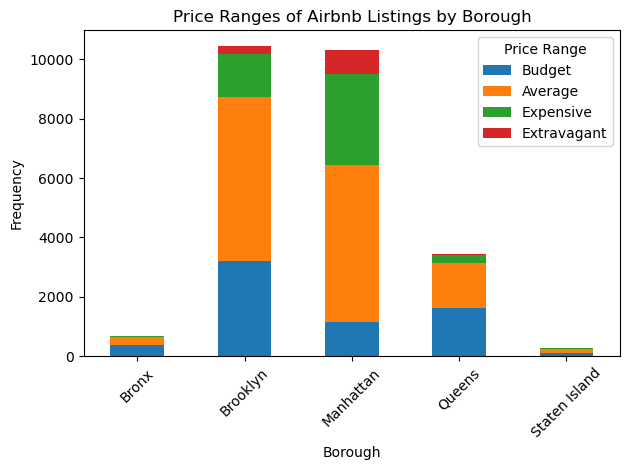

In [11]:
# Create a stacked bar chart of price ranges by borough
prices_by_borough.unstack().plot(kind="bar", stacked=True)
plt.xlabel("Borough")
plt.ylabel("Frequency")
plt.title("Price Ranges of Airbnb Listings by Borough")
plt.xticks(rotation=45)
plt.legend(title="Price Range")
plt.tight_layout()
plt.show()
